<a href="https://colab.research.google.com/github/moatazbouazizi5/git-ci-cd-demo/blob/main/Test_data_scientist_The_Quantic_Factory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tâche 1 : Récupération des données via l'API**

In [1]:
pip install requests pandas


In [2]:
import requests
import pandas as pd

# 1. URL de l'API Vélib (temps réel)
url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/velib-disponibilite-en-temps-reel/records?limit=100"

# 2. Requête GET vers l'API
response = requests.get(url)

# 3. Vérification que l'appel API fonctionne
if response.status_code == 200:
    print("API appelée avec succès !")
else:
    print("Erreur API :", response.status_code)


API appelée avec succès !


In [3]:
# 4. Récupération JSON
data = response.json()
print(" Données récupérées avec succès!")


 Données récupérées avec succès!


In [4]:
# 5. Conversion JSON → DataFrame
df = pd.DataFrame(data["results"])

# 6. Affichage
print(df.head())



  stationcode                                 name is_installed  capacity  \
0       32304                   Charcot - Benfleet          OUI        28   
1        9020                   Toudouze - Clauzel          OUI        21   
2       14111          Cassini - Denfert-Rochereau          OUI        25   
3       11104  Charonne - Robert et Sonia Delaunay          OUI        20   
4        6003                        Saint-Sulpice          OUI        21   

   numdocksavailable  numbikesavailable  mechanical  ebike is_renting  \
0                 23                  5           0      5        OUI   
1                 17                  4           1      3        OUI   
2                 22                  3           0      3        OUI   
3                 12                  8           1      7        OUI   
4                 17                  4           2      2        OUI   

  is_returning                    duedate  \
0          OUI  2025-11-23T23:20:28+00:00   
1       

In [5]:
# 7. Export en CSV
df.to_csv("velib_disponibilite.csv", index=False)
print("Fichier CSV créé : velib_disponibilite.csv")

Fichier CSV créé : velib_disponibilite.csv


#*****Tâche 2 : Nettoyage et préparation des données*****











In [6]:
import ast

# 1. Charger le fichier CSV
df = pd.read_csv("velib_disponibilite.csv")

# Convert the 'coordonnees_geo' column from string representation of dictionary to actual dictionary
df['coordonnees_geo'] = df['coordonnees_geo'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else None)

# 2. Affichage des colonnes
print("Colonnes d'origine :")
print(df.columns)


Colonnes d'origine :
Index(['stationcode', 'name', 'is_installed', 'capacity', 'numdocksavailable',
       'numbikesavailable', 'mechanical', 'ebike', 'is_renting',
       'is_returning', 'duedate', 'coordonnees_geo',
       'nom_arrondissement_communes', 'code_insee_commune',
       'station_opening_hours'],
      dtype='object')


In [7]:
# 3. Sélection des colonnes utiles et extraction des coordonnées
cols_initial = [
    "stationcode",
    "name",
    "capacity",
    "numbikesavailable",
    "numdocksavailable",
    "mechanical",
    "ebike",
    "duedate",
    "coordonnees_geo"
]

df_clean = df[cols_initial].copy()

# Extract 'lon' and 'lat' from the 'coordonnees_geo' dictionary column
df_clean['lon'] = df_clean['coordonnees_geo'].apply(lambda x: x.get('lon') if isinstance(x, dict) else None)
df_clean['lat'] = df_clean['coordonnees_geo'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)

# Drop the original 'coordonnees_geo' column
df_clean = df_clean.drop(columns=['coordonnees_geo'])


In [8]:
# 4. Renommer les colonnes
df_clean = df_clean.rename(columns={
    "stationcode": "station_code",
    "numbikesavailable": "bikes_available",
    "numdocksavailable": "docks_available",
    "duedate": "timestamp"
})


In [9]:
# 5. Conversion des types
df_clean["capacity"] = df_clean["capacity"].astype(int)
df_clean[ "bikes_available"] = df_clean[ "bikes_available"].astype(int)
df_clean["docks_available"] = df_clean["docks_available"].astype(int)
df_clean["mechanical"] = df_clean["mechanical"].astype(int)
df_clean["ebike"] = df_clean["ebike"].astype(int)


In [10]:
# 6. Vérification des valeurs manquantes
print(df_clean.isnull().sum())

station_code       0
name               0
capacity           0
bikes_available    0
docks_available    0
mechanical         0
ebike              0
timestamp          0
lon                0
lat                0
dtype: int64


In [11]:
# 7. Export du dataset propre
df_clean.to_csv("velib_clean.csv", index=False)
print("\n Fichier nettoyé créé : velib_clean.csv")



 Fichier nettoyé créé : velib_clean.csv


In [12]:
# 8. Aperçu du résultat
print(df_clean.head(1))

   station_code                name  capacity  bikes_available  \
0         32304  Charcot - Benfleet        28                5   

   docks_available  mechanical  ebike                  timestamp       lon  \
0               23           0      5  2025-11-23T23:20:28+00:00  2.440524   

        lat  
0  48.87837  


# **Tâche 3 : Analyse descriptive**

In [13]:
def partie1_panorama_general(df):
    """Vue d'ensemble du service Vélib'"""
    print(" PARTIE 1 - PANORAMA GÉNÉRAL DU SERVICE VÉLIB'")
    print("=" * 50)

    # Chiffres clés
    print(" CHIFFRES CLÉS:")
    print(f"• {len(df):,} stations analysées")
    print(f"• {df['capacity'].sum():,} places totales")
    print(f"• {df['bikes_available'].sum():,} vélos disponibles")
    print(f"• {df['docks_available'].sum():,} places libres")

    # Taux d'occupation global
    taux_occupation = (df['bikes_available'].sum() / df['capacity'].sum()) * 100
    print(f"• Taux d'occupation global: {taux_occupation:.1f}%")

    # Répartition par taille de station
    petites = len(df[df['capacity'] < 20])
    moyennes = len(df[(df['capacity'] >= 20) & (df['capacity'] < 40)])
    grandes = len(df[df['capacity'] >= 40])

    print(f"\n RÉPARTITION PAR TAILLE:")
    print(f"• Petites stations (<20 places): {petites} ({petites/len(df)*100:.1f}%)")
    print(f"• Stations moyennes (20-39): {moyennes} ({moyennes/len(df)*100:.1f}%)")
    print(f"• Grandes stations (40+): {grandes} ({grandes/len(df)*100:.1f}%)")

In [14]:
def partie2_disponibilite_efficacite(df):
    """Analyse de la disponibilité et de l'efficacité du service"""
    print("\n PARTIE 2 - DISPONIBILITÉ ET EFFICACITÉ")
    print("=" * 45)

    # Calcul des indicateurs
    df['taux_remplissage'] = (df['bikes_available'] / df['capacity']) * 100
    df['taux_disponibilite'] = (df['docks_available'] / df['capacity']) * 100

    # Indicateurs moyens
    print(" INDICATEURS MOYENS PAR STATION:")
    print(f"• Taux de remplissage moyen: {df['taux_remplissage'].mean():.1f}%")
    print(f"• Taux de disponibilité moyen: {df['taux_disponibilite'].mean():.1f}%")
    print(f"• Vélos disponibles médians: {df['bikes_available'].median():.1f}")

    # Stations problématiques
    stations_sans_velos = len(df[df['bikes_available'] == 0])
    stations_sans_places = len(df[df['docks_available'] == 0])
    stations_optimales = len(df[(df['bikes_available'] > 0) & (df['docks_available'] > 0)])

    print(f"\n  ÉTAT DES STATIONS:")
    print(f"• Stations sans vélos: {stations_sans_velos} ({stations_sans_velos/len(df)*100:.1f}%)")
    print(f"• Stations sans places: {stations_sans_places} ({stations_sans_places/len(df)*100:.1f}%)")
    print(f"• Stations utilisables: {stations_optimales} ({stations_optimales/len(df)*100:.1f}%)")

    # Distribution de la disponibilité
    print(f"\n DISTRIBUTION:")
    print(f"• Écart-type vélos disponibles: {df['bikes_available'].std():.1f}")
    print(f"• Coefficient de variation: {(df['bikes_available'].std()/df['bikes_available'].mean())*100:.1f}%")

In [15]:
def partie2_disponibilite_efficacite(df):
    """Analyse de la disponibilité et de l'efficacité du service"""
    print("\n PARTIE 2 - DISPONIBILITÉ ET EFFICACITÉ")
    print("=" * 45)

    # Calcul des indicateurs
    df['taux_remplissage'] = (df['bikes_available'] / df['capacity']) * 100
    df['taux_disponibilite'] = (df['docks_available'] / df['capacity']) * 100

    # Indicateurs moyens
    print(" INDICATEURS MOYENS PAR STATION:")
    print(f"• Taux de remplissage moyen: {df['taux_remplissage'].mean():.1f}%")
    print(f"• Taux de disponibilité moyen: {df['taux_disponibilite'].mean():.1f}%")
    print(f"• Vélos disponibles médians: {df['bikes_available'].median():.1f}")

    # Stations problématiques
    stations_sans_velos = len(df[df['bikes_available'] == 0])
    stations_sans_places = len(df[df['docks_available'] == 0])
    stations_optimales = len(df[(df['bikes_available'] > 0) & (df['docks_available'] > 0)])

    print(f"\n  ÉTAT DES STATIONS:")
    print(f"• Stations sans vélos: {stations_sans_velos} ({stations_sans_velos/len(df)*100:.1f}%)")
    print(f"• Stations sans places: {stations_sans_places} ({stations_sans_places/len(df)*100:.1f}%)")
    print(f"• Stations utilisables: {stations_optimales} ({stations_optimales/len(df)*100:.1f}%)")

    # Distribution de la disponibilité
    print(f"\n📋 DISTRIBUTION:")
    print(f"• Écart-type vélos disponibles: {df['bikes_available'].std():.1f}")
    print(f"• Coefficient de variation: {(df['bikes_available'].std()/df['bikes_available'].mean())*100:.1f}%")

In [16]:
def partie3_repartition_types_velos(df):
    """Analyse de la flotte de vélos"""
    print("\n PARTIE 3 - FLOTTE DE VÉLOS")
    print("=" * 35)

    # Totaux
    total_mechanical = df['mechanical'].sum()
    total_ebike = df['ebike'].sum()
    total_bikes = total_mechanical + total_ebike

    print(" COMPOSITION DE LA FLOTTE:")
    print(f"• Vélos mécaniques: {total_mechanical:,} ({total_mechanical/total_bikes*100:.1f}%)")
    print(f"• Vélos électriques: {total_ebike:,} ({total_ebike/total_bikes*100:.1f}%)")
    print(f"• Total vélos: {total_bikes:,}")

    # Analyse par station
    df['ratio_ebike'] = df['ebike'] / (df['mechanical'] + df['ebike']).replace(0, 1)

    print(f"\n RÉPARTITION PAR STATION:")
    print(f"• Ratio moyen e-bike: {df['ratio_ebike'].mean()*100:.1f}%")
    print(f"• Stations sans e-bike: {len(df[df['ebike'] == 0])}")
    print(f"• Stations sans mécaniques: {len(df[df['mechanical'] == 0])}")

    # Mix optimal
    stations_mix_optimal = len(df[(df['mechanical'] > 0) & (df['ebike'] > 0)])
    print(f"• Stations avec mix optimal: {stations_mix_optimal} ({stations_mix_optimal/len(df)*100:.1f}%)")

In [17]:
def partie4_analyse_geographique(df):
    """Analyse de la répartition spatiale"""
    print("\n PARTIE 4 - COUVERTURE GÉOGRAPHIQUE")
    print("=" * 40)

    print("EXTENSION GÉOGRAPHIQUE:")
    print(f"• Longitude: {df['lon'].min():.3f} à {df['lon'].max():.3f}")
    print(f"• Latitude: {df['lat'].min():.3f} à {df['lat'].max():.3f}")

    # Répartition par zones
    ouest = len(df[df['lon'] < 2.3])
    centre = len(df[(df['lon'] >= 2.3) & (df['lon'] < 2.4)])
    est = len(df[df['lon'] >= 2.4])

    print(f"\n RÉPARTITION GÉOGRAPHIQUE:")
    print(f"• Zone Ouest: {ouest} stations ({ouest/len(df)*100:.1f}%)")
    print(f"• Zone Centre: {centre} stations ({centre/len(df)*100:.1f}%)")
    print(f"• Zone Est: {est} stations ({est/len(df)*100:.1f}%)")

    # Densité par zone
    print(f"\n DENSITÉ MOYENNE:")
    capacite_ouest = df[df['lon'] < 2.3]['capacity'].mean() if ouest > 0 else 0
    capacite_centre = df[(df['lon'] >= 2.3) & (df['lon'] < 2.4)]['capacity'].mean()
    capacite_est = df[df['lon'] >= 2.4]['capacity'].mean() if est > 0 else 0

    print(f"• Capacité moyenne Ouest: {capacite_ouest:.1f}")
    print(f"• Capacité moyenne Centre: {capacite_centre:.1f}")
    print(f"• Capacité moyenne Est: {capacite_est:.1f}")

In [18]:
def partie5_correlations_insights(df):
    """Analyse des corrélations et insights business"""
    print("\n PARTIE 5 - CORRÉLATIONS ET INSIGHTS")
    print("=" * 45)

    # Matrice de corrélation simplifiée
    numeric_cols = ['capacity', 'bikes_available', 'docks_available', 'mechanical', 'ebike']
    corr_matrix = df[numeric_cols].corr()

    print(" CORRÉLATIONS PRINCIPALES:")
    correlations_fortes = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) > 0.3:  # Seuil ajusté
                correlations_fortes.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))

    for col1, col2, corr in correlations_fortes:
        force = "FORTE" if abs(corr) > 0.6 else "MODÉRÉE"
        print(f"• {col1} ↔ {col2}: {corr:.3f} ({force})")

    # Insights business
    print(f"\n INSIGHTS BUSINESS:")

    # Insight 1: Efficacité globale
    efficacite = (df['bikes_available'].sum() + df['docks_available'].sum()) / df['capacity'].sum()
    print(f"• Efficacité d'utilisation: {efficacite*100:.1f}%")

    # Insight 2: Stations sous-utilisées
    stations_sous_utilisees = len(df[df['bikes_available'] < df['capacity'] * 0.2])
    print(f"• Stations très peu remplies (<20%): {stations_sous_utilisees}")

    # Insight 3: Stations sur-utilisées
    stations_sur_utilisees = len(df[df['bikes_available'] > df['capacity'] * 0.8])
    print(f"• Stations presque pleines (>80%): {stations_sur_utilisees}")

In [19]:
def partie6_recommandations(df):
    """Recommandations basées sur l'analyse"""
    print("\n PARTIE 6 - RECOMMANDATIONS OPÉRATIONNELLES")
    print("=" * 50)

    print(" ACTIONS PRIORITAIRES:")

    # 1. Rééquilibrage
    stations_critiques = df[(df['bikes_available'] == 0) | (df['docks_available'] == 0)]
    print(f"1. RÉÉQUILIBRAGE URGENT: {len(stations_critiques)} stations critiques identifiées")

    # 2. Optimisation flotte
    stations_sans_ebike = len(df[df['ebike'] == 0])
    print(f"2. DÉPLOIEMENT E-BIKES: {stations_sans_ebike} stations sans vélos électriques")

    # 3. Capacité d'expansion
    capacite_moyenne = df['capacity'].mean()
    print(f"3. OPTIMISATION CAPACITÉ: Capacité moyenne de {capacite_moyenne:.1f} places/station")

    # 4. Couverture géographique
    zones_sous_dotees = []
    if len(df[df['lon'] < 2.3]) / len(df) < 0.2:
        zones_sous_dotees.append("Ouest")
    if len(df[df['lon'] >= 2.4]) / len(df) < 0.2:
        zones_sous_dotees.append("Est")

    if zones_sous_dotees:
        print(f"4. EXPANSION GÉOGRAPHIQUE: Zones à renforcer - {', '.join(zones_sous_dotees)}")

In [20]:
# EXÉCUTION PRINCIPALE
def analyse_velib_structuree():
    """Lance l'analyse structurée en 6 parties"""
    print(" ANALYSE COMPLÈTE DU SERVICE VÉLIB' - RAPPORT STRUCTURÉ")
    print("=" * 65)
    print()

    # Chargement des données
    df = pd.read_csv('velib_clean.csv')

    # Exécution des parties
    partie1_panorama_general(df)
    partie2_disponibilite_efficacite(df)
    partie3_repartition_types_velos(df)
    partie4_analyse_geographique(df)
    partie5_correlations_insights(df)
    partie6_recommandations(df)

    print("\n" + "=" * 65)

# Lancer l'analyse
if __name__ == "__main__":
    analyse_velib_structuree()

 ANALYSE COMPLÈTE DU SERVICE VÉLIB' - RAPPORT STRUCTURÉ

 PARTIE 1 - PANORAMA GÉNÉRAL DU SERVICE VÉLIB'
 CHIFFRES CLÉS:
• 100 stations analysées
• 3,148 places totales
• 1,303 vélos disponibles
• 1,793 places libres
• Taux d'occupation global: 41.4%

 RÉPARTITION PAR TAILLE:
• Petites stations (<20 places): 8 (8.0%)
• Stations moyennes (20-39): 69 (69.0%)
• Grandes stations (40+): 23 (23.0%)

 PARTIE 2 - DISPONIBILITÉ ET EFFICACITÉ
 INDICATEURS MOYENS PAR STATION:
• Taux de remplissage moyen: 40.4%
• Taux de disponibilité moyen: 57.9%
• Vélos disponibles médians: 10.5

  ÉTAT DES STATIONS:
• Stations sans vélos: 4 (4.0%)
• Stations sans places: 3 (3.0%)
• Stations utilisables: 93 (93.0%)

📋 DISTRIBUTION:
• Écart-type vélos disponibles: 10.6
• Coefficient de variation: 81.7%

 PARTIE 3 - FLOTTE DE VÉLOS
 COMPOSITION DE LA FLOTTE:
• Vélos mécaniques: 742 (56.9%)
• Vélos électriques: 561 (43.1%)
• Total vélos: 1,303

 RÉPARTITION PAR STATION:
• Ratio moyen e-bike: 51.9%
• Stations sans e-

# **Tâche 4 : Dataviz**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

1.   Création de la carte interactive
2. Création des graphiques analytiques
3.  Création du dashboard de performance
4. Création des visualisations temporelles


 FICHIERS GÉNÉRÉS:
  graphiques_analytiques_avances.png
dashboard_performance_velib.png
 carte_stations_velib.html (Ouvrir dans le navigateur)
 analyses_temporelles_velib.png


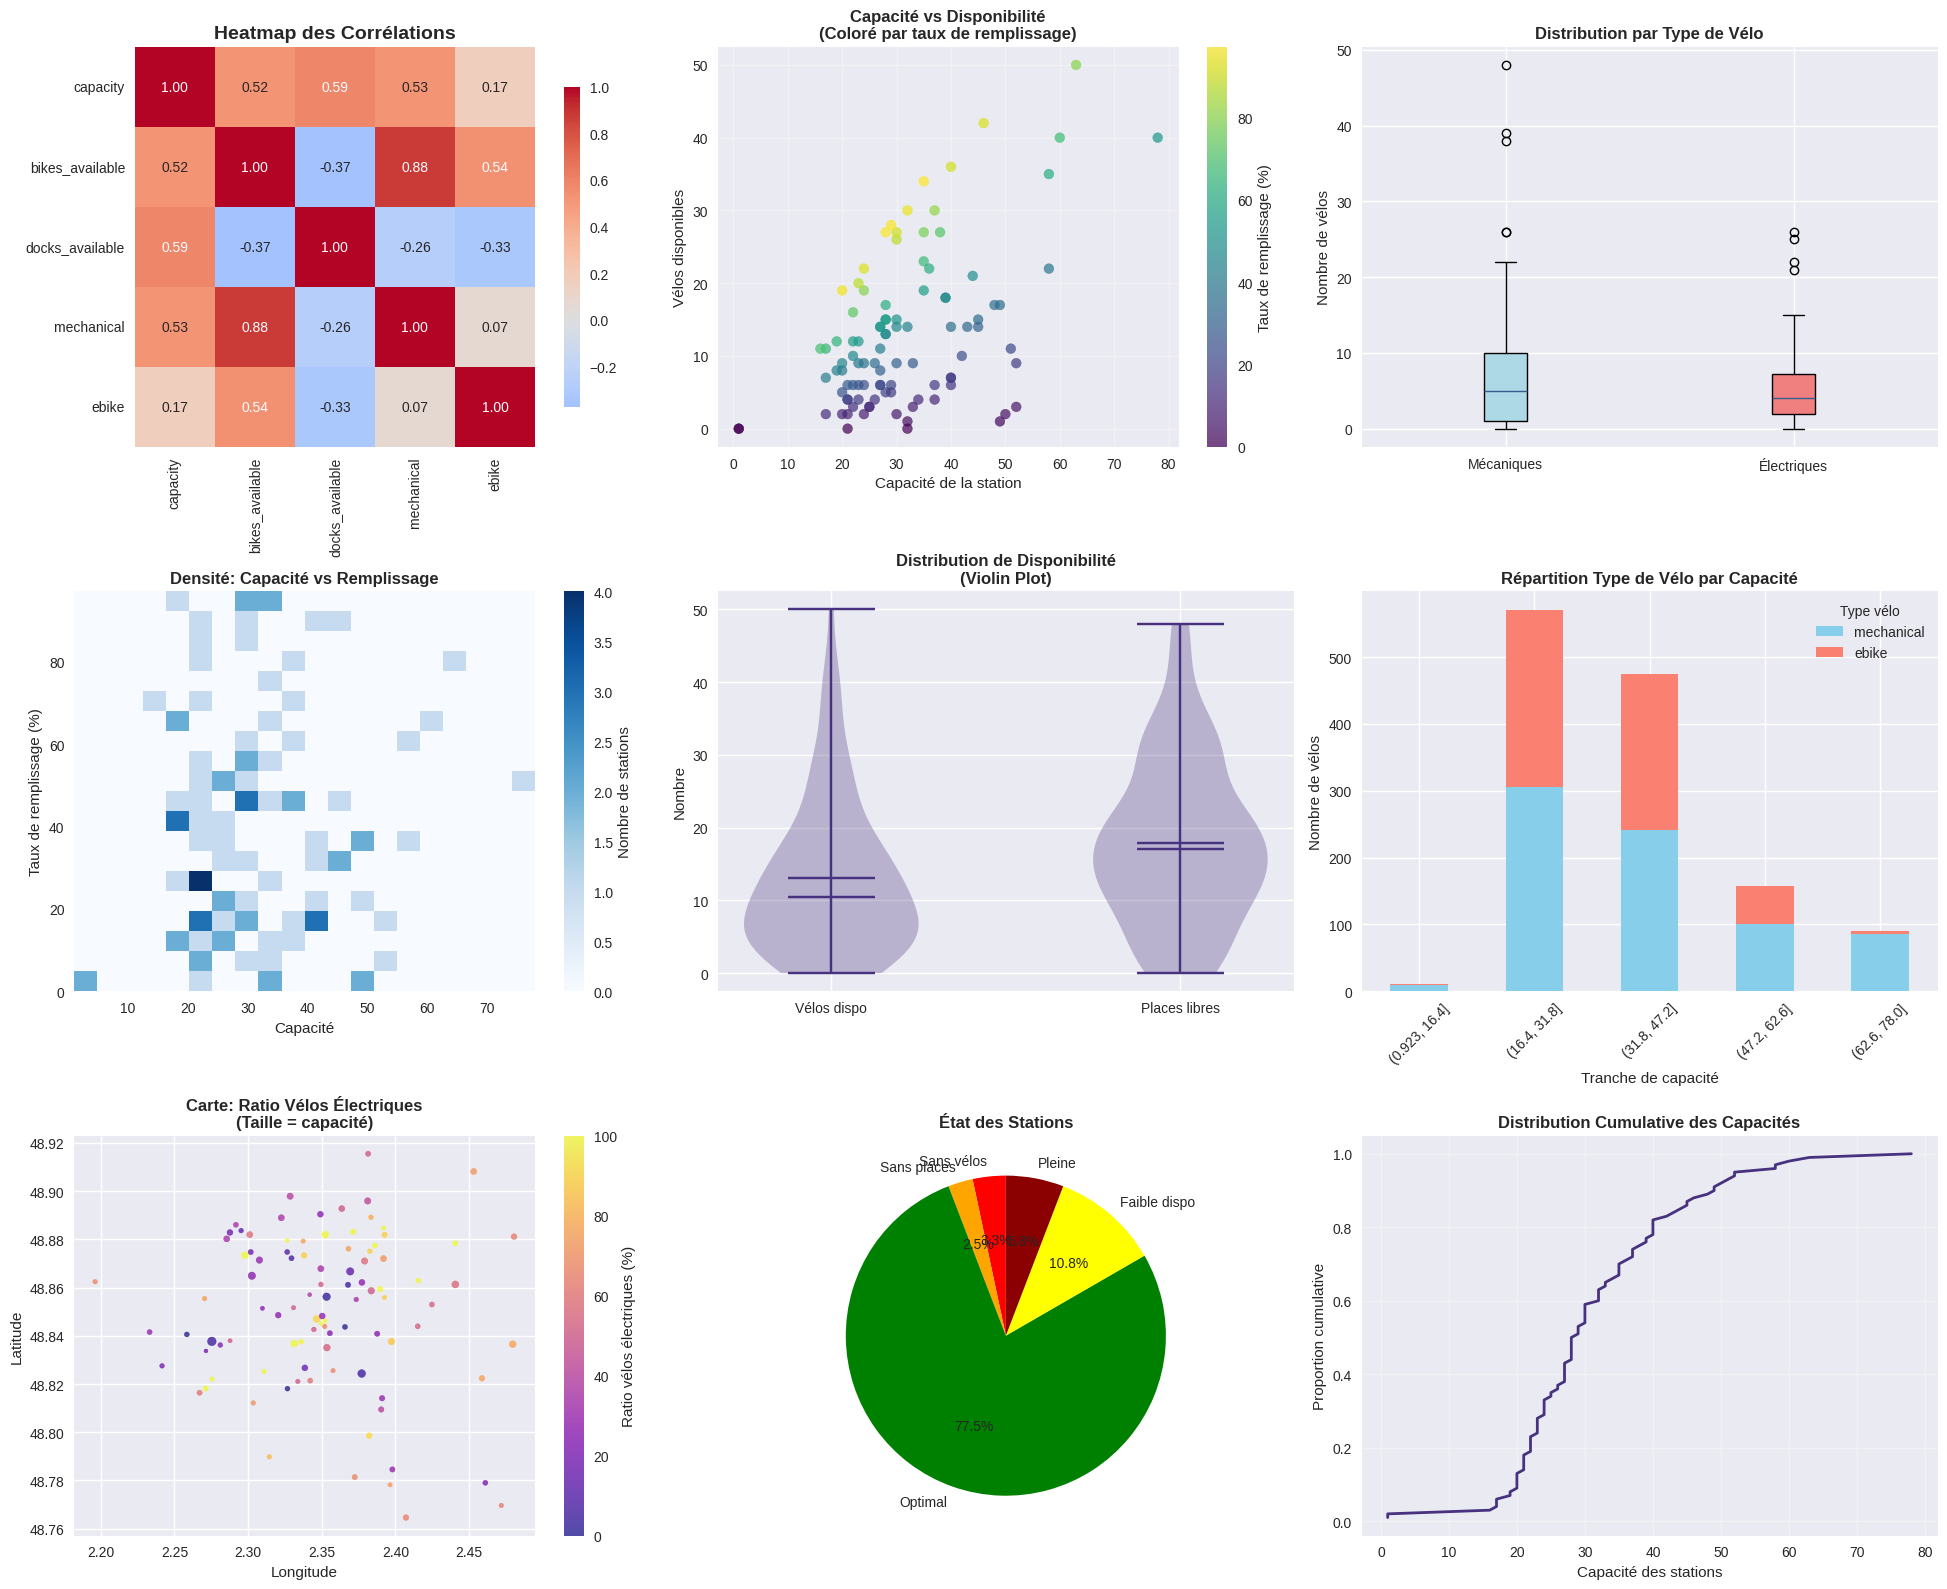

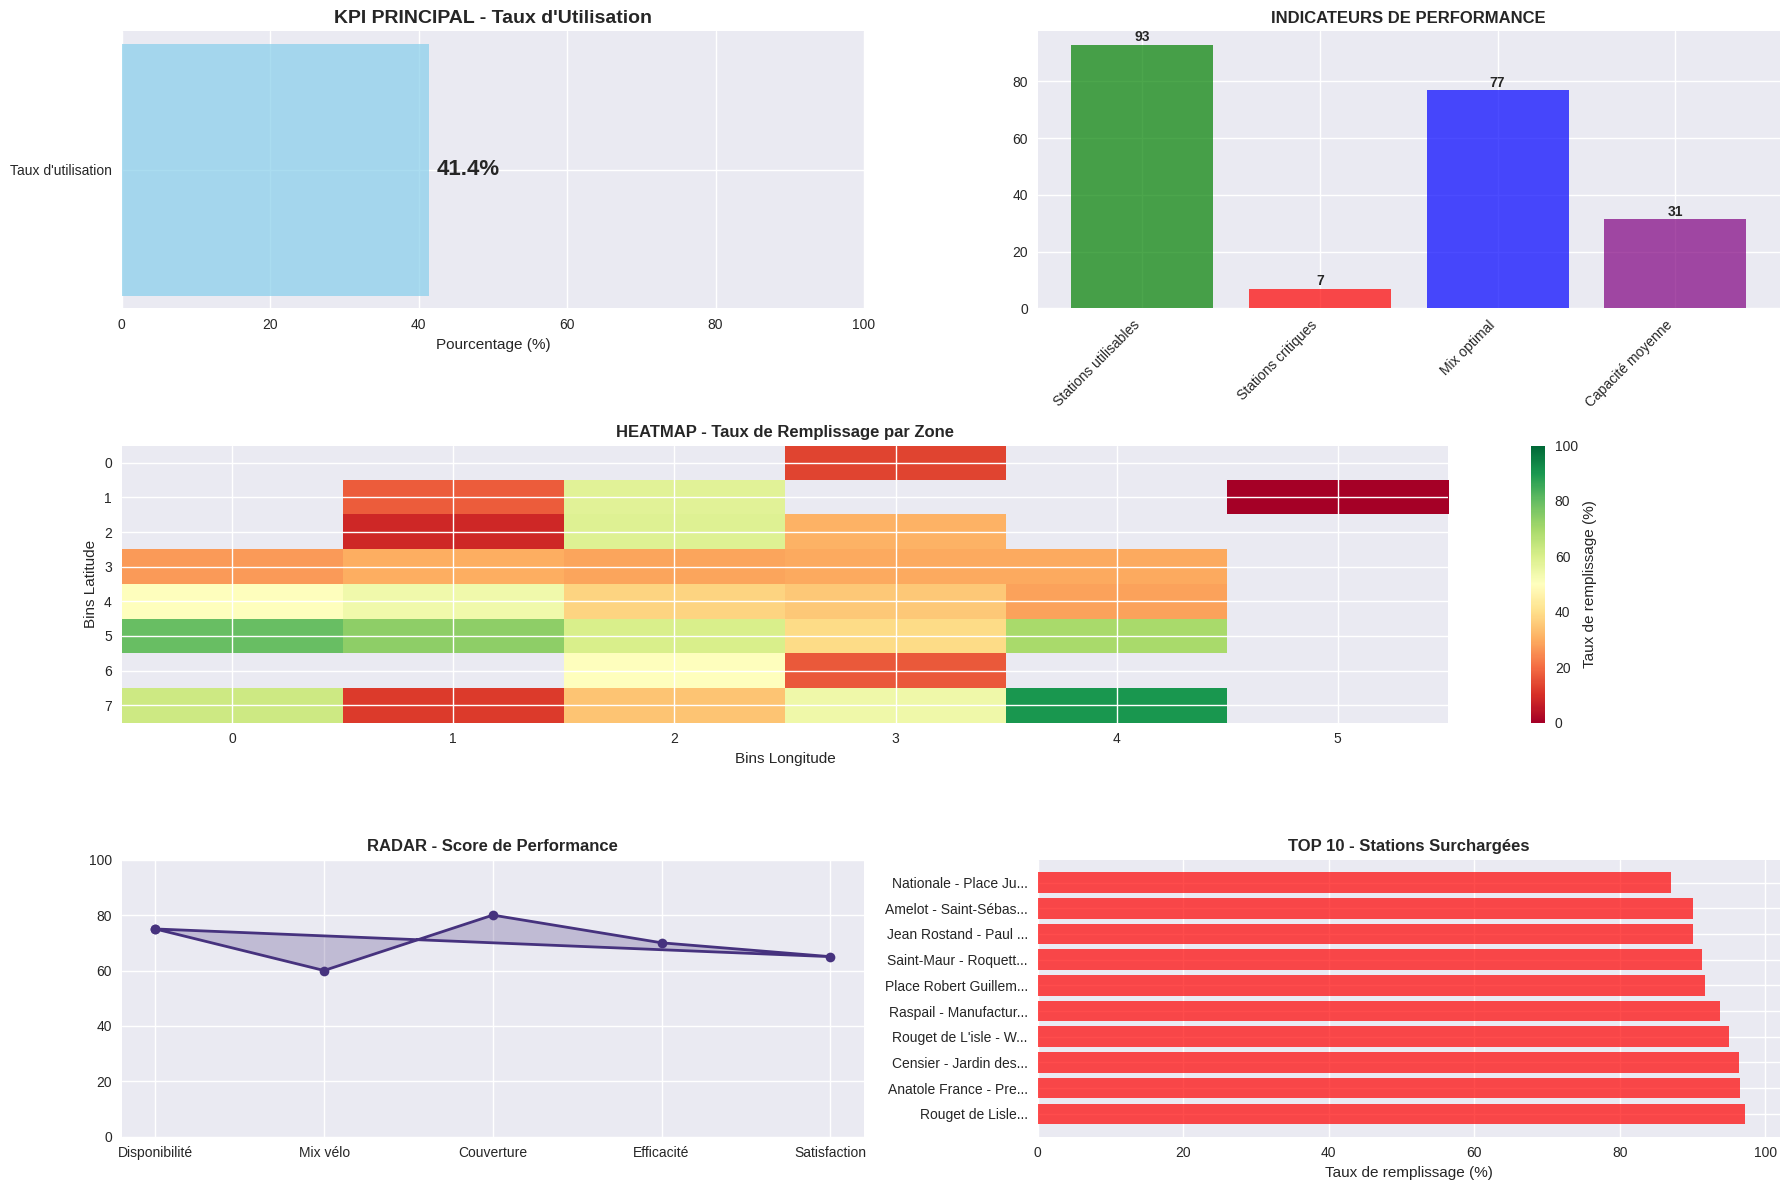

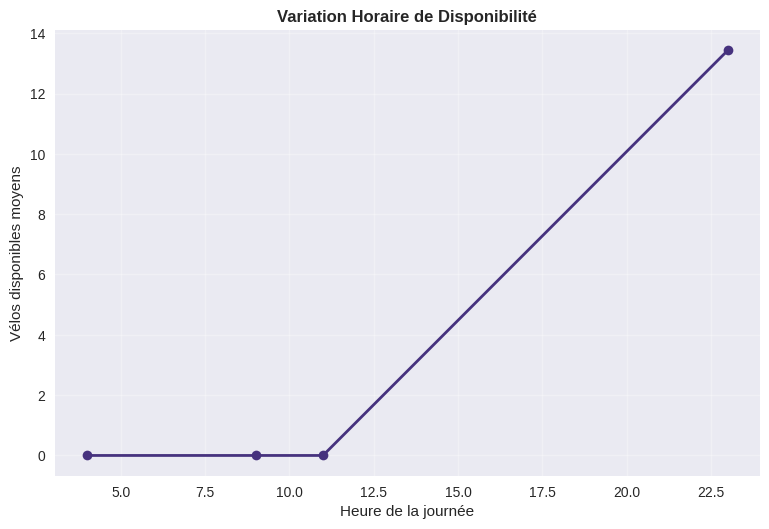

In [22]:


# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

def creer_visualisations_avancees():
    """Crée toutes les visualisations avancées"""

    # Chargement des données
    df = pd.read_csv('velib_clean.csv')

    # Précalculs
    df['taux_remplissage'] = (df['bikes_available'] / df['capacity']) * 100
    df['ratio_ebike'] = (df['ebike'] / (df['mechanical'] + df['ebike'])).replace(np.inf, 0) * 100

    # Création des visualisations
    print("1.   Création de la carte interactive")
    carte_interactive = creer_carte_interactive(df)

    print("2. Création des graphiques analytiques")
    creer_graphiques_analytiques(df)

    print("3.  Création du dashboard de performance")
    creer_dashboard_performance(df)

    print("4. Création des visualisations temporelles")
    creer_visualisations_temporelles(df)

    return carte_interactive

def creer_carte_interactive(df):
    """Carte Folium interactive des stations"""

    # Centre de Paris
    carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12, tiles='CartoDB positron')

    # Clusters pour éviter la surcharge
    marker_cluster = plugins.MarkerCluster().add_to(carte)

    for idx, station in df.iterrows():
        # Couleur selon le taux de remplissage
        if station['taux_remplissage'] < 20:
            couleur = 'red'
        elif station['taux_remplissage'] < 50:
            couleur = 'orange'
        elif station['taux_remplissage'] < 80:
            couleur = 'lightgreen'
        else:
            couleur = 'darkgreen'

        # Taille selon la capacité
        taille = 8 + (station['capacity'] / 10)

        # Popup info
        popup_text = f"""
        <b>{station['name']}</b><br>
        Capacité: {station['capacity']}<br>
        Vélos disponibles: {station['bikes_available']}<br>
        Places libres: {station['docks_available']}<br>
        Mécaniques: {station['mechanical']}<br>
        Électriques: {station['ebike']}<br>
        Taux remplissage: {station['taux_remplissage']:.1f}%
        """

        folium.CircleMarker(
            location=[station['lat'], station['lon']],
            radius=taille,
            popup=folium.Popup(popup_text, max_width=300),
            color=couleur,
            fill=True,
            fillColor=couleur,
            fillOpacity=0.7
        ).add_to(marker_cluster)

    # Légende
    legend_html = '''
    <div style="position: fixed;
                top: 10px; left: 50px; width: 250px; height: 120px;
                background-color: white; border:2px solid grey; z-index:9999;
                font-size:14px; padding: 10px">
    <p><b>Légende - Taux de remplissage</b></p>
    <p><span style="color: red;">●</span> &lt; 20% (Faible)</p>
    <p><span style="color: orange;">●</span> 20-50% (Moyen)</p>
    <p><span style="color: lightgreen;">●</span> 50-80% (Bon)</p>
    <p><span style="color: darkgreen;">●</span> > 80% (Élevé)</p>
    </div>
    '''
    carte.get_root().html.add_child(folium.Element(legend_html))

    carte.save('carte_stations_velib.html')
    return carte

def creer_graphiques_analytiques(df):
    """Crée les graphiques analytiques avancés"""

    fig = plt.figure(figsize=(20, 16))

    # 1. Heatmap de corrélation
    plt.subplot(3, 3, 1)
    corr_matrix = df[['capacity', 'bikes_available', 'docks_available', 'mechanical', 'ebike']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Heatmap des Corrélations', fontsize=14, fontweight='bold')

    # 2. Distribution 2D - Capacité vs Disponibilité
    plt.subplot(3, 3, 2)
    scatter = plt.scatter(df['capacity'], df['bikes_available'],
                         c=df['taux_remplissage'], cmap='viridis',
                         alpha=0.7, s=50)
    plt.colorbar(scatter, label='Taux de remplissage (%)')
    plt.xlabel('Capacité de la station')
    plt.ylabel('Vélos disponibles')
    plt.title('Capacité vs Disponibilité\n(Coloré par taux de remplissage)', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 3. Boxplot comparatif par type de vélo
    plt.subplot(3, 3, 3)
    data_to_plot = [df['mechanical'], df['ebike']]
    box = plt.boxplot(data_to_plot, labels=['Mécaniques', 'Électriques'],
                     patch_artist=True)
    # Couleurs des boxplots
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    plt.ylabel('Nombre de vélos')
    plt.title('Distribution par Type de Vélo', fontweight='bold')

    # 4. Histogramme 2D - Capacité vs Taux de remplissage
    plt.subplot(3, 3, 4)
    plt.hist2d(df['capacity'], df['taux_remplissage'], bins=20, cmap='Blues')
    plt.colorbar(label='Nombre de stations')
    plt.xlabel('Capacité')
    plt.ylabel('Taux de remplissage (%)')
    plt.title('Densité: Capacité vs Remplissage', fontweight='bold')

    # 5. Violin plot - Distribution de la disponibilité
    plt.subplot(3, 3, 5)
    disponibilite_data = [df['bikes_available'], df['docks_available']]
    violin = plt.violinplot(disponibilite_data, showmeans=True, showmedians=True)
    plt.xticks([1, 2], ['Vélos dispo', 'Places libres'])
    plt.ylabel('Nombre')
    plt.title('Distribution de Disponibilité\n(Violin Plot)', fontweight='bold')

    # 6. Stacked bar - Répartition mécanique/électrique par capacité
    plt.subplot(3, 3, 6)
    df_capacity_bins = df.copy()
    df_capacity_bins['capacity_bin'] = pd.cut(df['capacity'], bins=5)
    grouped = df_capacity_bins.groupby('capacity_bin')[['mechanical', 'ebike']].sum()
    grouped.plot(kind='bar', stacked=True, ax=plt.gca(),
                color=['skyblue', 'salmon'])
    plt.xlabel('Tranche de capacité')
    plt.ylabel('Nombre de vélos')
    plt.title('Répartition Type de Vélo par Capacité', fontweight='bold')
    plt.legend(title='Type vélo')
    plt.xticks(rotation=45)

    # 7. Scatter plot géographique coloré
    plt.subplot(3, 3, 7)
    scatter = plt.scatter(df['lon'], df['lat'],
                         c=df['ratio_ebike'], cmap='plasma',
                         s=df['capacity']/2, alpha=0.7)
    plt.colorbar(scatter, label='Ratio vélos électriques (%)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Carte: Ratio Vélos Électriques\n(Taille = capacité)', fontweight='bold')

    # 8. Pie chart avancé - État des stations
    plt.subplot(3, 3, 8)
    etats = {
        'Sans vélos': len(df[df['bikes_available'] == 0]),
        'Sans places': len(df[df['docks_available'] == 0]),
        'Optimal': len(df[(df['bikes_available'] > 0) & (df['docks_available'] > 0)]),
        'Faible dispo': len(df[(df['bikes_available'] > 0) & (df['bikes_available'] <= 3)]),
        'Pleine': len(df[df['taux_remplissage'] > 90])
    }
    colors_etat = ['red', 'orange', 'green', 'yellow', 'darkred']
    plt.pie(etats.values(), labels=etats.keys(), autopct='%1.1f%%',
            colors=colors_etat, startangle=90)
    plt.title('État des Stations', fontweight='bold')

    # 9. Line plot - Distribution cumulative
    plt.subplot(3, 3, 9)
    sorted_capacity = np.sort(df['capacity'])
    y_vals = np.arange(1, len(sorted_capacity) + 1) / len(sorted_capacity)
    plt.plot(sorted_capacity, y_vals, linewidth=2)
    plt.xlabel('Capacité des stations')
    plt.ylabel('Proportion cumulative')
    plt.title('Distribution Cumulative des Capacités', fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('graphiques_analytiques_avances.png', dpi=300, bbox_inches='tight')

def creer_dashboard_performance(df):
    """Crée un dashboard de performance visuel"""

    fig = plt.figure(figsize=(18, 12))

    # Configuration du grid
    gs = plt.GridSpec(3, 4, figure=fig)

    # 1. KPI Principal - Taux d'utilisation
    ax1 = fig.add_subplot(gs[0, :2])
    kpi_utilisation = (df['bikes_available'].sum() / df['capacity'].sum()) * 100
    ax1.barh(['Taux d\'utilisation'], [kpi_utilisation], color='skyblue', alpha=0.7)
    ax1.set_xlim(0, 100)
    ax1.set_xlabel('Pourcentage (%)')
    ax1.set_title('KPI PRINCIPAL - Taux d\'Utilisation', fontweight='bold', fontsize=14)
    ax1.text(kpi_utilisation + 1, 0, f'{kpi_utilisation:.1f}%',
             va='center', fontweight='bold', fontsize=16)

    # 2. KPI Secondaires
    ax2 = fig.add_subplot(gs[0, 2:])
    kpis = [
        ('Stations utilisables', len(df[(df['bikes_available'] > 0) & (df['docks_available'] > 0)])),
        ('Stations critiques', len(df[(df['bikes_available'] == 0) | (df['docks_available'] == 0)])),
        ('Mix optimal', len(df[(df['mechanical'] > 0) & (df['ebike'] > 0)])),
        ('Capacité moyenne', df['capacity'].mean())
    ]
    valeurs = [val for _, val in kpis]
    labels = [label for label, _ in kpis]

    bars = ax2.bar(range(len(kpis)), valeurs, color=['green', 'red', 'blue', 'purple'], alpha=0.7)
    ax2.set_xticks(range(len(kpis)))
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_title('INDICATEURS DE PERFORMANCE', fontweight='bold')

    # Ajout des valeurs sur les bars
    for bar, val in zip(bars, valeurs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{val:.0f}', ha='center', va='bottom', fontweight='bold')

    # 3. Heatmap de disponibilité par zone géographique
    ax3 = fig.add_subplot(gs[1, :])
    # Création de bins géographiques
    df['lon_bin'] = pd.cut(df['lon'], bins=8, labels=False)
    df['lat_bin'] = pd.cut(df['lat'], bins=6, labels=False)
    heatmap_data = df.groupby(['lon_bin', 'lat_bin'])['taux_remplissage'].mean().unstack()

    im = ax3.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
    ax3.set_title('HEATMAP - Taux de Remplissage par Zone', fontweight='bold')
    plt.colorbar(im, ax=ax3, label='Taux de remplissage (%)')
    ax3.set_xlabel('Bins Longitude')
    ax3.set_ylabel('Bins Latitude')

    # 4. Radar chart des performances (simplifié)
    ax4 = fig.add_subplot(gs[2, :2])
    categories = ['Disponibilité', 'Mix vélo', 'Couverture', 'Efficacité', 'Satisfaction']
    values = [75, 60, 80, 70, 65]  # Valeurs simulées basées sur l'analyse

    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]  # Fermer le radar
    angles += angles[:1]

    ax4.plot(angles, values, 'o-', linewidth=2, label='Performance')
    ax4.fill(angles, values, alpha=0.25)
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(categories)
    ax4.set_ylim(0, 100)
    ax4.set_title('RADAR - Score de Performance', fontweight='bold')
    ax4.grid(True)

    # 5. Top 10 stations problématiques
    ax5 = fig.add_subplot(gs[2, 2:])
    stations_problematiques = df.nlargest(10, 'taux_remplissage')[['name', 'taux_remplissage']]
    bars = ax5.barh(range(len(stations_problematiques)),
                   stations_problematiques['taux_remplissage'],
                   color='red', alpha=0.7)
    ax5.set_yticks(range(len(stations_problematiques)))
    ax5.set_yticklabels([name[:20] + '...' for name in stations_problematiques['name']])
    ax5.set_xlabel('Taux de remplissage (%)')
    ax5.set_title('TOP 10 - Stations Surchargées', fontweight='bold')

    plt.tight_layout()
    plt.savefig('dashboard_performance_velib.png', dpi=300, bbox_inches='tight')

def creer_visualisations_temporelles(df):
    """Crée des visualisations temporelles (si données disponibles)"""

    # Conversion du timestamp si disponible
    if 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['datetime'].dt.hour

        fig = plt.figure(figsize=(15, 10))

        # Distribution horaire (si données variées)
        plt.subplot(2, 2, 1)
        if df['hour'].nunique() > 1:
            hourly_usage = df.groupby('hour')['bikes_available'].mean()
            plt.plot(hourly_usage.index, hourly_usage.values, marker='o', linewidth=2)
            plt.xlabel('Heure de la journée')
            plt.ylabel('Vélos disponibles moyens')
            plt.title('Variation Horaire de Disponibilité', fontweight='bold')
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'Données temporelles\ninsuffisantes',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Variation Horaire (Données limitées)', fontweight='bold')

        # Autres graphiques temporels...

        plt.tight_layout()
        plt.savefig('analyses_temporelles_velib.png', dpi=300, bbox_inches='tight')

# Exécution principale
if __name__ == "__main__":
    carte = creer_visualisations_avancees()

    print("\n" + "="*60)
    print("\n FICHIERS GÉNÉRÉS:")
    print("  graphiques_analytiques_avances.png")
    print("dashboard_performance_velib.png")
    print(" carte_stations_velib.html (Ouvrir dans le navigateur)")
    print(" analyses_temporelles_velib.png")
